In [ ]:
%pip install torch
%pip install transformers

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # URL'leri kaldır
    tweet = re.sub(r'@\S+', '', tweet)  # Kullanıcı adlarını kaldır
    tweet = re.sub(r'#\S+', '', tweet)  # Hashtag'leri kaldır
    tweet = re.sub(r'RT\s+', '', tweet)  # RT etiketlerini kaldır
    "tweet = re.sub(r'[0-9]+', '', tweet)  # Sayıları kaldır"
    tweet = re.sub(r'[^\w\s]', '', tweet) # Noktalama işaretlerini ve özel karakterleri kaldır
    return tweet.strip()

In [2]:
def predict_sentiment(tweet, threshold=0.3):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    with torch.no_grad():
        outputs = model(tokens)
        probabilities = softmax(outputs.logits, dim=1).squeeze()

    max_prob, predicted_class = torch.max(probabilities, dim=0)

    if max_prob > threshold:
        if predicted_class == 0:
            return "Very Negative"
        elif predicted_class == 1:
            return "Negative"
        elif predicted_class == 2:
            return "Neutral"
        elif predicted_class == 3:
            return "Positive"
        elif predicted_class == 4:
            return "Very Positive"
    return "Neutral"

In [3]:
def process_sentiment(df):
    # Tarih sütununu tarih türüne dönüştürmek
    df['Date'] = pd.to_datetime(df['Date'])

    # Puanları kategorize eden fonksiyonlar
    def positive(x): return x > 0
    def negative(x): return x < 0
    def neutral(x): return x == 0

    # Günlük bazda puanları saymak
    grouped = df.groupby('Date')['Sentiment_Point'].agg(
        positive_count=lambda x: x.apply(positive).sum(),
        negative_count=lambda x: x.apply(negative).sum(),
        neutral_count=lambda x: x.apply(neutral).sum()
    )

    return grouped.reset_index()

In [4]:
def merge_dataframes(df1, df2):
    merged_df = pd.merge(df1, df2, on='Date', how='inner')
    return merged_df

In [ ]:
tweet = pd.read_csv("stock_tweets.csv")

In [ ]:
tweet_tesla = tweet[tweet["Company Name"] ==  'Tesla, Inc.']
tweet_tesla.head()

In [ ]:
tesla_tweets = tweet[tweet["Company Name"] ==  'Tesla, Inc.']['Tweet']
tweet_tesla['Cleaned_Tweet']  = tesla_tweets.apply(clean_tweet)

In [ ]:
tweet_tesla.sample(5)

In [ ]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

In [ ]:
tweet_tesla['BERT_sentiment_label'] = tweet_tesla["Cleaned_Tweet"].apply(predict_sentiment)

In [6]:
tweet_tesla["Sentiment_Point"] = 0

In [7]:
sentiment_mapping = {"Very Negative" : -2,
                    "Negative" : -1,
                    "Neutral" : 0,
                    "Positive" : 1,
                    "Very Positive" : 2}

In [8]:
def assign_sentiment_point(row):
    return sentiment_mapping[row['BERT_sentiment_label']]

tweet_tesla['Sentiment_Point'] = tweet_tesla.apply(assign_sentiment_point, axis=1)

In [9]:
tweet_tesla["Date"] = pd.to_datetime(tweet_tesla["Date"]).dt.date

In [10]:
sentiment_point_total = tweet_tesla.groupby('Date')['Sentiment_Point'].sum().reset_index()

In [11]:
sentiment_count = process_sentiment(tweet_tesla)

In [12]:
sentiment_point_total["Date"] = pd.to_datetime(sentiment_point_total["Date"])

In [13]:
sentiment_data = pd.merge(sentiment_point_total,sentiment_count,how='left',on=["Date"])

In [27]:
labels = pd.DataFrame(tweet_tesla.groupby(["BERT_sentiment_label"]).count()["Sentiment_Point"])

In [29]:
labels.rename(columns={"Sentiment_Point" : })

,Count
BERT_sentiment_label,
Negative,2305
Neutral,8402
Positive,1774
Very Negative,14312
Very Positive,10629


In [14]:
sentiment_data["total_tweet_count"] = sentiment_data["positive_count"] + sentiment_data["negative_count"] + sentiment_data["neutral_count"]

In [15]:
stock_finance_data = pd.read_csv("stock_yfinance_data.csv")

In [16]:
tesla_stock_finance =stock_finance_data[stock_finance_data["Stock Name"] == "TSLA"]

In [17]:
tesla_stock_finance["Close_Diff"] = tesla_stock_finance["Close"].pct_change()
tesla_stock_finance.drop(["Open","High","Low","Adj Close","Volume"], axis = 1,inplace=True)
tesla_stock_finance["Date"] = pd.to_datetime(tesla_stock_finance["Date"])

/var/folders/0t/rpp9ntlx6xl16gfchdbbwjd83b2ts6/T/ipykernel_1603/1105791712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_stock_finance["Close_Diff"] = tesla_stock_finance["Close"].pct_change()
/var/folders/0t/rpp9ntlx6xl16gfchdbbwjd83b2ts6/T/ipykernel_1603/1105791712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_stock_finance.drop(["Open","High","Low","Adj Close","Volume"], axis = 1,inplace=True)
/var/folders/0t/rpp9ntlx6xl16gfchdbbwjd83b2ts6/T/ipykernel_1603/1105791712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [18]:
stock_and_sentiment_merged = pd.merge(sentiment_data,tesla_stock_finance,how="left",on=["Date"])

In [19]:
new_new_df_weekdays = sentiment_data[sentiment_data['Date'].dt.dayofweek < 5]
merged_df_weekdays = merge_dataframes(new_new_df_weekdays, tesla_stock_finance)
merged_df_weekdays = merged_df_weekdays.dropna(subset=['Sentiment_Point', 'Close_Diff'])
merged_df_weekdays = merged_df_weekdays.replace([np.inf, -np.inf], np.nan).dropna(subset=['Sentiment_Point', 'Close_Diff'])


correlation_weekdays = merged_df_weekdays['Sentiment_Point'].corr(merged_df_weekdays['Close_Diff'])

# 2. Hafta Sonu Verilerini Cuma Gününe Yuvarlayarak Korelasyon Hesaplama
new_new_df_friday = sentiment_data.copy()
new_new_df_friday['Date'] = new_new_df_friday['Date'].apply(lambda x: x - pd.Timedelta(days=x.dayofweek - 4) if x.dayofweek > 4 else x)
merged_df_friday = merge_dataframes(new_new_df_friday, tesla_stock_finance)
merged_df_friday = merged_df_friday.dropna(subset=['Sentiment_Point', 'Close_Diff'])
merged_df_friday = merged_df_friday.replace([np.inf, -np.inf], np.nan).dropna(subset=['Sentiment_Point', 'Close_Diff'])

correlation_friday = merged_df_friday['Sentiment_Point'].corr(merged_df_friday['Close_Diff'])


# 3. Hafta Sonu Verilerini Pazartesi Gününe Yuvarlayarak Korelasyon Hesaplama
new_new_df_monday = sentiment_data.copy()
new_new_df_monday['Date'] = new_new_df_monday['Date'].apply(lambda x: x + pd.Timedelta(days=7 - x.dayofweek) if x.dayofweek > 4 else x)
merged_df_monday = merge_dataframes(new_new_df_monday, tesla_stock_finance)
merged_df_monday = merged_df_monday.dropna(subset=['Sentiment_Point', 'Close_Diff'])
merged_df_monday = merged_df_monday.replace([np.inf, -np.inf], np.nan).dropna(subset=['Sentiment_Point', 'Close_Diff'])

correlation_monday = merged_df_monday['Sentiment_Point'].corr(merged_df_monday['Close_Diff'])

# Korelasyon değerlerini yazdırma
print("Hafta içi verileriyle korelasyon:", correlation_weekdays)
print("Cuma gününe yuvarlanmış verilerle korelasyon:", correlation_friday)
print("Pazartesi gününe yuvarlanmış verilerle korelasyon:", correlation_monday)

Hafta içi verileriyle korelasyon: 0.2588187470603457
Cuma gününe yuvarlanmış verilerle korelasyon: 0.18490240004507474
Pazartesi gününe yuvarlanmış verilerle korelasyon: 0.25230507568651056


In [20]:
merged_data_df = pd.merge(tesla_stock_finance, tweet_tesla, on=['Date', 'Stock Name'], how='inner')

tesla_data_df = merged_data_df[merged_data_df['Stock Name'] == 'TSLA']

# Checking the merged and processed data
tesla_data_df.head()


,Date,Close,Stock Name,Close_Diff,Tweet,Company Name,Cleaned_Tweet,BERT_sentiment_label,Sentiment_Point
0,2021-09-30,258.493347,TSLA,NaN,#LottoFriday Watchlist: short &amp; sweet\n\n$...,"Tesla, Inc.",Watchlist short amp sweet\n\nAMD over 1045 105...,Neutral,0
1,2021-09-30,258.493347,TSLA,NaN,CORRECTION UPDATE\n\nUPDATE on Q3 Delivery Est...,"Tesla, Inc.",CORRECTION UPDATE\n\nUPDATE on Q3 Delivery Est...,Neutral,0
2,2021-09-30,258.493347,TSLA,NaN,FREE #OPTIONS Ideas 🤯\n\nScale out when above ...,"Tesla, Inc.",FREE Ideas \n\nScale out when above 25 Profit...,Neutral,0
3,2021-09-30,258.493347,TSLA,NaN,California DMV today issued autonomous vehicle...,"Tesla, Inc.",California DMV today issued autonomous vehicle...,Very Positive,2
4,2021-09-30,258.493347,TSLA,NaN,@chamath Appreciate the clarification @chamath...,"Tesla, Inc.",Appreciate the clarification We all know how ...,Positive,1


In [21]:
a = stock_and_sentiment_merged

# Öncelikle, NaN olmayan satırlar için bir mask oluşturulur.
not_nan_mask = a['Close'].notna() & a['Stock Name'].notna() & a['Close_Diff'].notna()

# NaN olan satırları bulmak için bu mask'ı ters çeviririz.
nan_mask = ~not_nan_mask

# NaN değerlerin olduğu satırların indekslerini alırız.
nan_indices = a.index[nan_mask]

# NaN olmayan değerlerin olduğu satırların indekslerini alırız.
not_nan_indices = a.index[not_nan_mask]

# NaN olan her satır için, diğer sütunların değerlerini NaN olmayan bir sonraki satıra ekleriz.
for nan_index in nan_indices:
    # Bir sonraki NaN olmayan satırın indeksini buluruz.
    next_not_nan_index = not_nan_indices[not_nan_indices > nan_index].min()
    
    # Eğer bir sonraki NaN olmayan satır varsa, toplama işlemini gerçekleştiririz.
    if pd.notnull(next_not_nan_index):
        for col in ['Sentiment_Point', 'positive_count', 'negative_count', 'neutral_count', 'total_tweet_count']:
            a.loc[next_not_nan_index, col] += a.loc[nan_index, col]

# NaN değerler içeren satırları siliyoruz.
a = a[not_nan_mask].reset_index(drop=True)

stock_and_sentiment_merged = a

In [22]:
stock_and_sentiment_merged["Moving Average-5"] = None
stock_and_sentiment_merged["Moving Average-5"] = stock_and_sentiment_merged["Close"].rolling(window=5).mean()

Mean Absolute Error (MAE): 8.926835027064682
Mean Squared Error (MSE): 148.70938786200873
Root Mean Squared Error (RMSE): 12.194645868659276
R-squared (R^2): 0.9363026735280405
Adjusted R-squared: 0.9335921489973189
Moving Average 5 MSE: 357.7014985481341
Eğitim Seti - Mean Absolute Error (MAE): 9.120928470426144
Eğitim Seti - Mean Squared Error (MSE): 149.45577707369196
Eğitim Seti - Root Mean Squared Error (RMSE): 12.22521071694439
Eğitim Seti - R-squared (R^2): 0.9263808839719311
Eğitim Seti - Adjusted R-squared: 0.9256334817787527


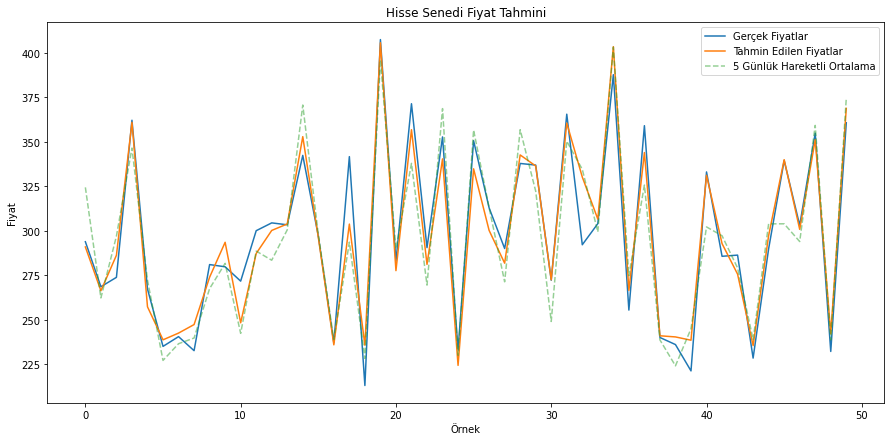

In [30]:
features_with_date = stock_and_sentiment_merged[['Close', 'Sentiment_Point',"Moving Average-5"]]

# Hedef değişkeni oluşturun
target = stock_and_sentiment_merged['Close'].shift(-1)

# Son satırı kaldırın
features_with_date = features_with_date[:-1]
target = target[:-1]

# Eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(features_with_date, target, test_size=0.2, random_state=42)

# Eğitim ve test setlerinden 'Date' sütununu ayırın ve saklayın
train_maFive = X_train['Moving Average-5']
test_maFive = X_test['Moving Average-5'].reset_index(drop=True)


# 'Date' sütununu özellik setlerinden kaldırın
X_train = X_train.drop(["Moving Average-5"], axis=1)
X_test = X_test.drop(["Moving Average-5"], axis=1)

# Özellikleri ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP Regressor modelini oluşturun ve eğitin
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Test seti üzerinde tahmin yapın
predictions = mlp.predict(X_test_scaled)
train_predictions = mlp.predict(X_train_scaled)


# Tahmin performansını değerlendirme (örnek olarak MSE kullanıyorum)

# MAE hesaplama
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# MSE hesaplama
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# RMSE hesaplama
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# R^2 hesaplama
r2 = r2_score(y_test, predictions)
print(f'R-squared (R^2): {r2}')

# Adjusted R^2 hesaplama
n = len(y_test)  # Örnek sayısı
p = X_test.shape[1]  # Özellik sayısı
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

mse_maFive = mean_squared_error(y_test, test_maFive)
print(f"Moving Average 5 MSE: {mse_maFive}")

train_mae = mean_absolute_error(y_train, train_predictions)
print(f'Eğitim Seti - Mean Absolute Error (MAE): {train_mae}')

# Eğitim seti için MSE hesaplama
train_mse = mean_squared_error(y_train, train_predictions)
print(f'Eğitim Seti - Mean Squared Error (MSE): {train_mse}')

# Eğitim seti için RMSE hesaplama
train_rmse = np.sqrt(train_mse)
print(f'Eğitim Seti - Root Mean Squared Error (RMSE): {train_rmse}')

# Eğitim seti için R^2 hesaplama
train_r2 = r2_score(y_train, train_predictions)
print(f'Eğitim Seti - R-squared (R^2): {train_r2}')

# Eğitim seti için Düzeltilmiş R^2 hesaplama
n = len(y_train)  # Örnek sayısı
p = X_train.shape[1]  # Özellik sayısı
train_adjusted_r2 = 1 - (1 - train_r2) * (n - 1) / (n - p - 1)
print(f'Eğitim Seti - Adjusted R-squared: {train_adjusted_r2}')

# Grafik boyutunu belirleyerek bir figür oluşturun
plt.figure(figsize=(15, 7))

plt.plot(y_test.values, label='Gerçek Fiyatlar')
plt.plot(predictions, label='Tahmin Edilen Fiyatlar')
plt.plot(test_maFive.values, label='5 Günlük Hareketli Ortalama', alpha=0.5, linestyle='--')
plt.title('Hisse Senedi Fiyat Tahmini')
plt.xlabel('Örnek')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

metrics = [mae,train_mae,mse,train_mse,rmse,train_rmse,r2,train_r2,adjusted_r2,train_adjusted_r2]

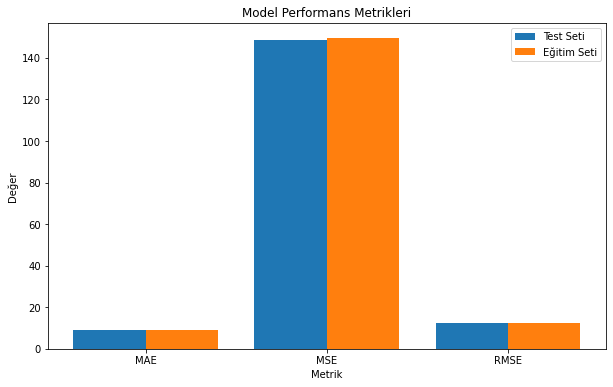

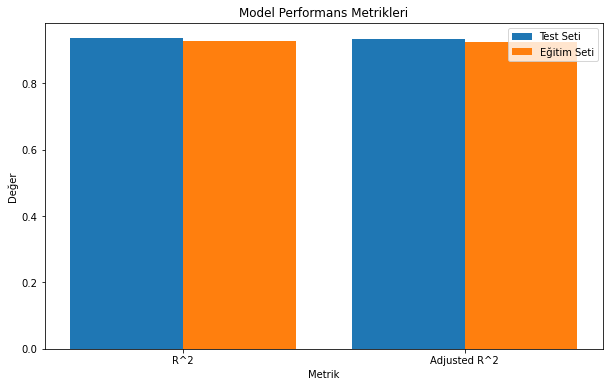

In [36]:
metrics = ['MAE', 'MSE', 'RMSE']
test_values = [mae, mse, rmse]
train_values = [train_mae, train_mse, train_rmse]

r2_metrics =['R^2', 'Adjusted R^2']
test_r2_metrics = [r2, adjusted_r2]
train_r2_metrics = [train_r2, train_adjusted_r2]

plt.figure(figsize=(10, 6))
plt.bar([x for x in range(len(metrics))], test_values, width=0.4, label='Test Seti', align='center')
plt.bar([x + 0.4 for x in range(len(metrics))], train_values, width=0.4, label='Eğitim Seti', align='center')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.title('Model Performans Metrikleri')
plt.xticks([x + 0.2 for x in range(len(metrics))], metrics)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.bar([x for x in range(len(r2_metrics))], test_r2_metrics, width=0.4, label='Test Seti', align='center')
plt.bar([x + 0.4 for x in range(len(r2_metrics))], train_r2_metrics, width=0.4, label='Eğitim Seti', align='center')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.title('Model Performans Metrikleri')
plt.xticks([x + 0.2 for x in range(len(r2_metrics))], r2_metrics)
plt.legend()
plt.show()
